# 000.12 -  PyUL_NBody Final Edition New Draft

## Document Created: Mon, 14 Sept 2020
## Internal

PyUltraLight with N-Body Addon

- Merged Notebook Improvements from 000.10

- N-Body Simulation Using Identical Syntax as Soliton IV
- Rudimentary interaction Models (Method = 1 and Method = 2)
- Field appropriately scaled for dynamics.
- Pre-Computed 2-Body Problem Example Scenarios (Parabola and Circular)
- Improved Movie Plotter Performance (Output to File or Inline)
- New 3d Volumetric Visualization (needs plotly)




# Housekeeping:

In [1]:
import os

save_path = 'FW_NBody'  # Set output directory


def get_size(start_path):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(start_path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            # skip if it is symbolic link
            if not os.path.islink(fp):
                total_size += os.path.getsize(fp)

    return total_size

print(save_path,": The current size of the folder is", round(get_size(save_path)/1024**2,3), 'Mib')

print(save_path,": Do You Wish to Delete All Files Currently Stored In This Folder? [Y] \n")


cleardir = str(input())

if cleardir == 'Y':
    import shutil 
    shutil.rmtree(save_path)
    print("Folder Cleaned! \n")

try:
    os.mkdir(save_path)
    print(save_path,": Save Folder Created.")
except FileExistsError:
    if cleardir != 'Y':
        print("Folder Retained")
    else:
        print(save_path,": File Already Exists!")

FW_NBody : The current size of the folder is 0.001 Mib
FW_NBody : Do You Wish to Delete All Files Currently Stored In This Folder? [Y] 

Y
Folder Cleaned! 

FW_NBody : Save Folder Created.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation

import PyUltraLight_NS as PyUL
print('PyUltralight: Integrator Date', PyUL.D_version())

import pyfftw
import os
import sys
import multiprocessing
import numpy
import numba
import h5py
from matplotlib import cm

import math

from IPython.core.display import clear_output, display
%matplotlib inline

PyUltralight: Integrator Date 2020 09 15 For 000.12


# Set Axion Mass (SI)

In [3]:
axion_mass = 1e-22 *1.783e-36 #kg

# ULDM Simulation Parameters

In [43]:
# Set number of threads to target
num_threads = multiprocessing.cpu_count()
print("Available CPU threads for this run: ",num_threads)

# Set units for soliton parameters
s_mass_unit = ''     #Accepted units: 'kg', 'solar_masses', 'M_solar_masses', and '' for dimensionless units
s_position_unit = '' #Accepted units: 'm', 'km', 'pc', 'kpc', 'Mpc', 'ly', and '' for dimensionless units
s_velocity_unit = '' #Accepted units: 'm/s', 'km/s', 'km/h', and '' for dimensionless units

# Rules ditto.
m_mass_unit = ''
m_position_unit = ''
m_velocity_unit = ''

# Set box size and resolution
length = 14 # 1 code unit is ~38 kpc x (1e-22/m_a)^0.5
length_units = ''  # Accepted units: 'm', 'km', 'pc', 'kpc', 'Mpc', 'ly', and '' for dimensionless units.

resolN = int(8) # 6 -> 64, 7 -> 128, 8 -> 256, 9 -> 512, 10 -> Explosion

resol= int(2**resolN)# It is recommended to check the upper bound on soliton mass for a given box size and resolution

print("Simulation Grid Resolution:", resol, 'cubed')

duration = 0.1 #1 code unit is ~70 Gyr (independent of axion mass assumption)
duration_units = ''  # Accepted units: 's', 'yr', 'kyr', 'Myr', and '' for dimensionless units
start_time = 0.05 # Should be given in the same units as duration. 

#Data to save
#0
save_rho = False # Saves density data for entire 3D simulation grid
#1
save_psi = False # Saves full complex field data for entire 3D simulation grid
#2
save_plane = True # Saves density data for plane z = 0
#3
save_energies = False # Saves integrated gravitational, kinetic and total energies as lists
#4
save_line = False # Saves density data for line y = 0, z = 0. Useful for examining intereference patterns. 
## FW
#5
save_testmass = True # Saves trajectory and 3-velocity of a test mass thrown into the system. 
                    #Please see PyUL_Floater's code header for documentation.
#Formats to save
hdf5 = False
npz = False
npy = True

step_factor = 1 # Change this to a larger number if velocities are sufficiently low that constraint on timestep can be relaxed. 
save_number = 120    # Choose number of 'frames' to save. Note that, depending on resolution, this could require significant disk space.


save_options = [save_rho,save_psi,save_plane,save_energies,save_line,save_testmass]

Available CPU threads for this run:  16
Simulation Grid Resolution: 256 cubed


# NBody Simulation Parameters:

In [44]:
# Nothing Goes Here For 000.12

# ULDM Initial Condition Modifier
If Uniform is set to true, this block overrides all solitons you put there

In [45]:
# Removes Solitons in the IV and replaces them with a uniform wavefunction 
# with given probability amplitude (code unit).

Uniform = True
Density = 0

central_mass = 0

 

# Gravitational Field Smoothing
Instead of coding in the idealistic $\frac{m}{r}$ potential, we approximate with $\frac{am}{ar+e^{-ar}}$. Over the length of the block. The smoothing factor, $a$, is also defined here.

The modified potential is a useful approximation of a point mass in a distance.

The differences between the two potentials are characterised in the following box.

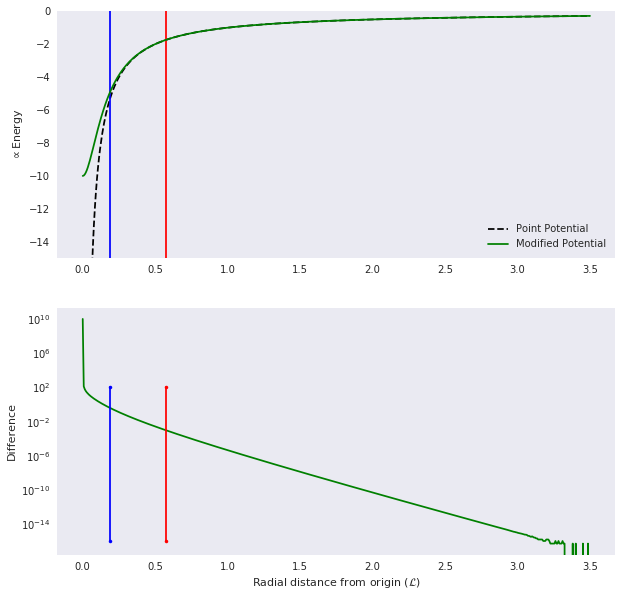



Radius outside which the fields are practically indistinguishable: 0.575

This is about 21.0 simulation grids per Cartesian axis


Modified Potential HWHM: 0.189

This is about 6.9 simulation grids per Cartesian axis


In [46]:
a = 10

fig_grav = plt.figure(figsize=(10, 10))

ax1 = plt.subplot(211)
ax2 = plt.subplot(212)

rR = np.linspace(1e-10,length/4,500)

GOrig = -1/rR

GMod = -a*1/(a*rR+np.exp(-a*rR))

GDiff = - GOrig + GMod

BoundaryEn = next(x for x, val in enumerate(GDiff) if val < 1e-3)
rS = rR[BoundaryEn]

BoundaryEx = next(x for x, val in enumerate(GMod) if val > -a/2)
rQ = rR[BoundaryEx]

ax1.plot(rR,GOrig,'k--',label = 'Point Potential')

ax1.plot([rS,rS],[2,-100],'r.-')
ax1.plot([rQ,rQ],[2,-100],'b.-')


ax1.plot(rR,GMod,'g-',label = 'Modified Potential')

ax1.set_ylim([-1.5*a,0])

ax1.legend()

ax1.set_ylabel('$\propto$Energy')
ax1.grid()

ax2.semilogy(rR,(GDiff),'g-')
ax2.set_xlabel('Radial distance from origin ($\mathcal{L}$)')
ax2.set_ylabel('Difference')
ax2.semilogy([rS,rS],[1e2,1e-16],'r.-')
ax2.semilogy([rQ,rQ],[1e2,1e-16],'b.-')
ax2.grid()

plt.show()


print('\n========================\n')
print("Radius outside which the fields are practically indistinguishable: %.3f\n" % rS)
print("This is about %.1f simulation grids per Cartesian axis" % ((2*rS)/float(length/resol))**1)

print('\n========================\n')
print("Modified Potential HWHM: %.3f\n" % rQ)
print("This is about %.1f simulation grids per Cartesian axis" % ((2*rQ)/float(length/resol))**1)

# Load Example Scenarios:

Just run the following blocks, and "False" scenarios will automatically skip.

If you want to specify your own settings, please set "Single_Mass_Trial" to True.

In [47]:
Parabola = True
Circular = False
Singe_Mass_Trial = False

Ratio = 0.8

## Parabola Injector

Describes two masses (soliton or BH or hybrid) with equal mass approaching each other on the $x-y$ plane.

You can specify the $(x_0,y_0)$ value, as well as their masses.

The rest of the initial conditions will then be automatically computed.

In [48]:
## Init
if Parabola:

    m = 10 #1 code unit is ~2.3e6 M_sol (1e-22/m_a)^1.5
    r = 0.5 #1 code unit is ~38 kpc x (1e-22/m_a)^0.5

    x0 = 2
    y0 = 2
    
    m1 = m
    m2 = m

    # Focal Point Is Origin
    # y^2 = 4cx + 4c^2

    c0 = 1/2*(-x0+np.sqrt(x0**2+y0**2))

    v0 = np.sqrt(m/(2*np.sqrt(x0**2+y0**2))) #Correct

    xDot0 = 1
    yDot0 = 2*c0*xDot0/(y0)

    vNorm = np.linalg.norm([xDot0,yDot0])

    xDot0 = xDot0/vNorm*v0
    yDot0 = yDot0/vNorm*v0

    BH1 = [m,[x0,y0,0],[-xDot0,-yDot0,0]]
    BH2 = [m,[-x0,-y0,0],[xDot0,yDot0,0]]
    
    
    BHT = [0,[0,0,0],[0,0,0]]
    particles = [BH1,BH2]


    #Soliton parameters are mass, position, velocity and phase (radians)
    soliton1 = [m, [x0,y0,0],[-xDot0,-yDot0,0], 0]
    soliton2 = [m, [-x0,-y0,0],[xDot0,yDot0,0], 0]

    solitons = [soliton1,soliton2]
    # solitons = []

else:
    print("Parameter loading skipped in this block.")

## Circular Orbit Injector

Describes two masses (soliton or BH or hybrid) with arbitrary masses orbiting each other on the $x-y$ plane.

You can specify the initial separation, as well as their individual masses.

The rest of the initial conditions will then be automatically computed.

In [49]:
if Circular:

    m1 = 50 #1 code unit is ~2.3e6 M_sol (1e-22/m_a)^1.5
    
    m2 = 50
    
    x1 = 0.7
    
    x2 = x1/m2*m1 # Ensures Com Position
    
    xC = x1+x2
    
    yDot1 = np.sqrt(m2*x1/xC**2)
    yDot2 = np.sqrt(m1*x2/xC**2)

           
    BH1 = [Ratio*m1,[x1,0,0],[0,yDot1,0]]
    BH2 = [Ratio*m2,[-x2,0,0],[0,-yDot2,0]]
    
    
    
    particles = [BH1,BH2]


    #Soliton parameters are mass, position, velocity and phase (radians)
    
    soliton1 = [(1-Ratio)*m1,[x1,0,0],[0,yDot1,0], 0]
    soliton2 = [(1-Ratio)*m2,[-x2,0,0],[0,-yDot2,0],0]
    
    solitonC = [10,[0,0,0],[0,0,0],0]

    solitons = [soliton1,soliton2]

    #solitons = [solitonC]
    

else:
    print("Parameter loading skipped in this block.")

Parameter loading skipped in this block.


## General Initial Settings

In [50]:
if Singe_Mass_Trial:
    
    central_mass = 0
    
    m1 = 100
    
    r = 0.95
    v = 4
    
    BH1 = [m1,[0,0,0],[0,0,0]]

    particles = [BH1]

    #Soliton parameters are mass, position, velocity and phase (radians)
    
    soliton1 = [10, [0,0,0],[0,0,0], 0]


    solitons = [soliton1]
    #solitons = []


    NumSol = len(solitons)
else:
    print("Parameter loading skipped in this block.")

Parameter loading skipped in this block.


# Main Execution Block:

In [51]:
try:
    TimeStamp = PyUL.evolve(central_mass, num_threads, length, length_units, 
            resol, duration, duration_units, step_factor, 
            save_number, save_options, save_path, npz, npy, hdf5, 
            s_mass_unit, s_position_unit, s_velocity_unit, solitons,
            start_time, m_mass_unit, m_position_unit, m_velocity_unit, particles,
            Uniform,Density,a)
    
except KeyboardInterrupt:
    print("\n Run Interrupted! The ability to resume simulations is under development.")



PyUL_NBody: Run Complete. Time Elapsed (d:h:m:s): 0:0:4:41


# Data Loading:


In [52]:
with open('{}{}'.format(save_path, '/timestamp.txt'), 'r') as timestamp:
    ts = timestamp.read()
    print('PyUL NBody: Loading Folder',ts)

loc = save_path + '/' + ts

import time   
import warnings 
warnings.filterwarnings("ignore")
plt.ioff()

EndNum = 0
data = []
TMdata = []

for x in np.arange(0,save_number+1,1):
#for x in np.arange(0,550,1):    
    
    try:
        
        data.append(np.load('{}{}{}{}'.format(loc, '/plane_#', x, '.npy')))
        TMdata.append(np.load('{}{}{}{}'.format(loc, '/TM_#', x, '.npy')))
        EndNum += 1
    except FileNotFoundError:
        
        TimeStamp = ts
        print("PyUL NBody: Run incomplete or the storage is corrupt!")

        break
        
print("PyUL NBody: Loaded", EndNum, "Data Entries")

PyUL NBody: Loading Folder 2020.9.15_03_10_27_256
PyUL NBody: Loaded 121 Data Entries


# 2D Trajectory Plot

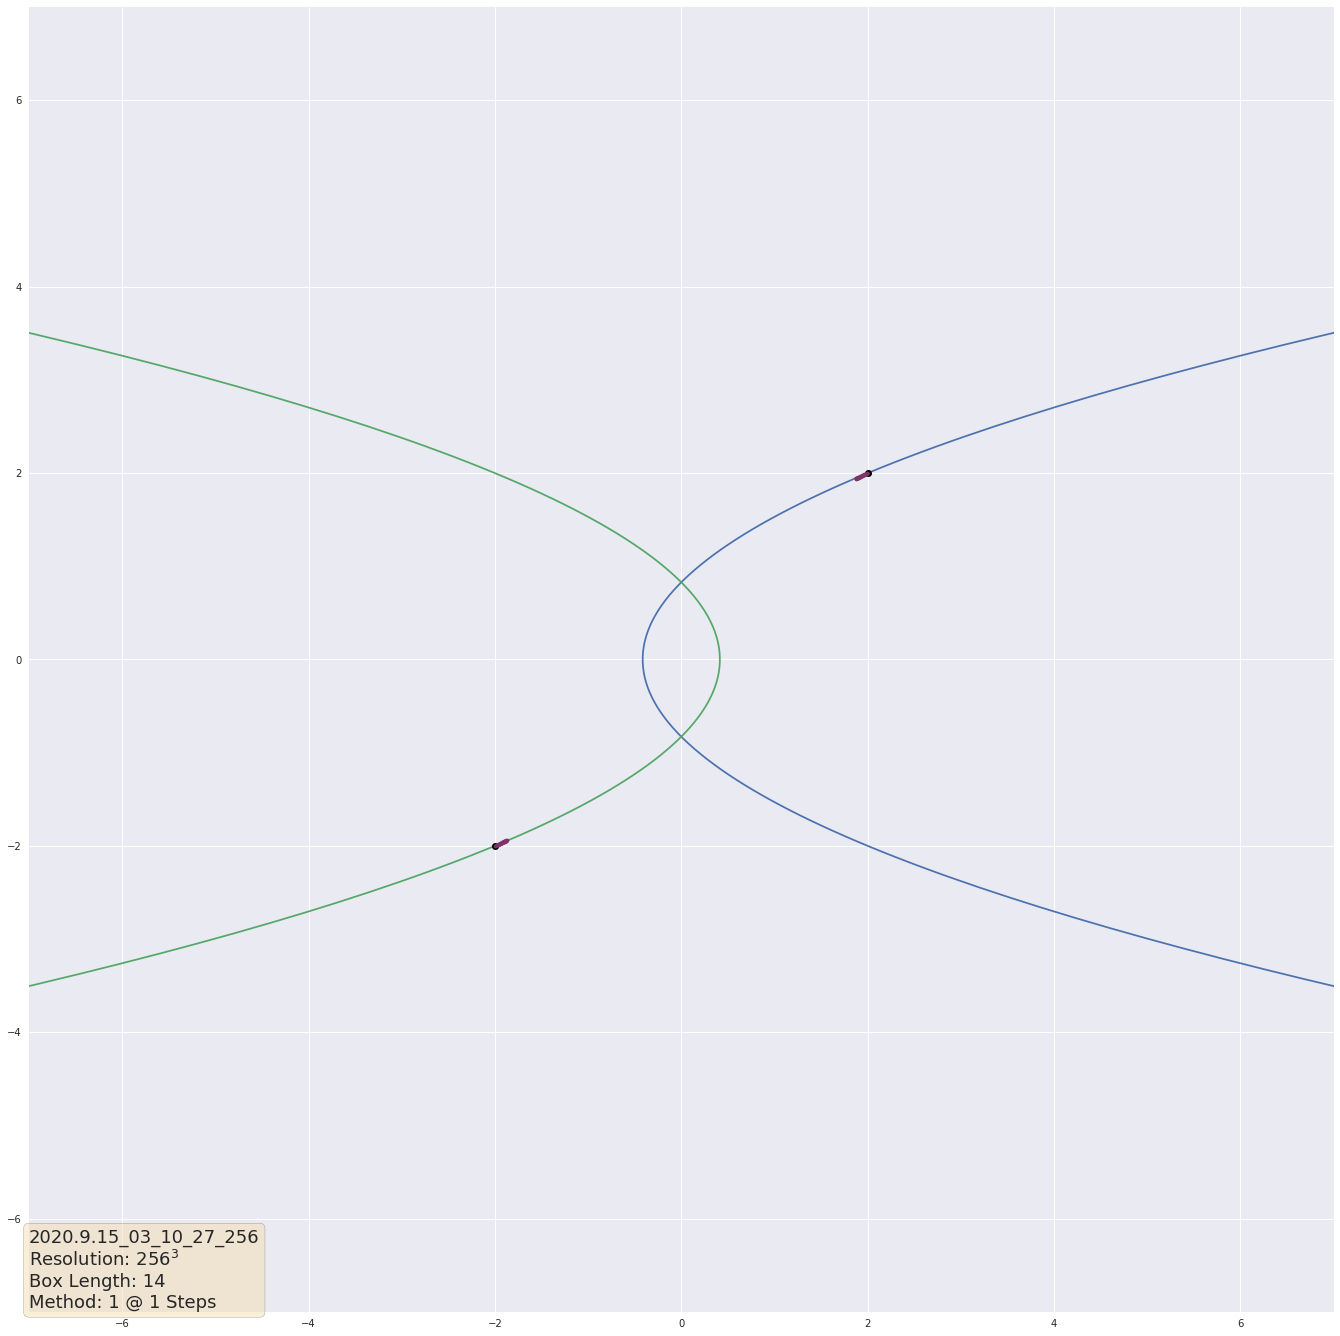

In [53]:
try:
    TSD = TimeStamp
except NameError:
    TimeStamp = 'Debug'

plt.clf()

fig = plt.figure(figsize=(24, 24))
# debug
import numexpr as ne
import matplotlib as mpl

Zoom2D = 1
Boundary = length/(2*Zoom2D)

ax = fig.add_subplot(111)
mpl.style.use('seaborn')

if Parabola:
    yParaBola = np.linspace(-length/(2),length/(2),resol)
    xParaBola = ne.evaluate("yParaBola**2/(4*c0)-c0")

    plt.plot(xParaBola,yParaBola)

    plt.plot(-xParaBola,yParaBola)
    

if Circular:
    
    tCirc = np.linspace(0,2*np.pi,200)

    plt.plot(x1*np.cos(tCirc),x1*np.sin(tCirc),'-',color = (1,0.5,0,0.1))
    plt.plot(x2*np.cos(tCirc),x2*np.sin(tCirc),'-',color = (1,0,0.5,0.1))



plt.xlim([-Boundary,Boundary])
plt.ylim([-Boundary,Boundary])


ax.set_aspect('equal', adjustable='box')

for i in range(EndNum):
    
    
    TMStateLoc = TMdata[i]
    
    if i == 0:
        for particleID in range(len(particles)):
        
            ColorID = particleID/len(particles) # 0, 0.5
        
            TMx = TMStateLoc[int(6*particleID)]
            TMy = TMStateLoc[int(6*particleID+1)]
            plt.plot([TMx],[TMy],'ko')
        
    
    Alpha = 0.3+7*i/(10*EndNum)
    
    for particleID in range(len(particles)):
        
        ColorID = 0.2 # 0, 0.5
        
        TMx = TMStateLoc[int(6*particleID)]
        TMy = TMStateLoc[int(6*particleID+1)]
        plt.plot([TMx],[TMy],'.',color=(0.5,1*ColorID,0.6-ColorID,Alpha))
        
ax.grid(True)



textstr = '\n'.join((
    TimeStamp,
    r'Resolution: $%.0f^3$' % (resol, ),
    r'Box Length: %.0f' % (length, ),
    r'Method: %.0f @ %.0f Steps' % (1,1)))

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0, 0, textstr, transform=ax.transAxes, fontsize=18,
        verticalalignment='bottom', bbox=props)

plt.show()

# 2D Animation Panel

In [29]:
Loga = False 
try:
    VTimeStamp = TimeStamp
except NameError:
    VTimeStamp = str('Debug')

AnimName = '{}{}{}{}'.format(save_path,"/Anim2D_",VTimeStamp,'.mp4')

print("Saving ",AnimName)

plot_axis = 'z' #axis that is set to zero
plt.ioff()
fig0, ax0 = plt.subplots(figsize=(16, 9), dpi=72)
ax0.set_aspect('equal')


if Loga:
    data0 = np.log(data)
    planemax = np.max(data0)
    planemin = -20
    
    print("Using Log Plot, the Contour Level Limits Are")
    print(planemax,planemin)
    
else:
    data0 = (data)
    planemax = np.max(data0)
    planemin = np.min(data0)
        
levels = np.linspace(planemin, planemax, int(resol))
PlotRange = np.linspace(-length/2, length/2,resol,endpoint = False)

FPS = 15


def animate0(i):
    ax0.cla()
    ax0.set_aspect('equal')
    ax0.set_xlim([-length/2,length/2])
    ax0.set_ylim([-length/2,length/2])
    ax0.get_xaxis().set_ticks([])
    ax0.get_yaxis().set_ticks([])
    ax0.contour(PlotRange,PlotRange,data0[i], levels=levels, vmin=planemin, vmax=planemax, cmap='coolwarm')
    #ax0.imshow(data[i])

    TMStateLoc = TMdata[i]
    for particleID in range(len(particles)):
        TMx = TMStateLoc[int(6*particleID)]
        TMy = TMStateLoc[int(6*particleID+1)]
        TMz = TMStateLoc[int(6*particleID+2)]
        
        Vx = TMStateLoc[int(6*particleID+3)]
        Vy = TMStateLoc[int(6*particleID+4)]
        Vz = TMStateLoc[int(6*particleID+5)]
        ax0.plot([TMy],[TMx],'ko')
        ax0.quiver([TMy],[TMx],[Vy],[Vx])
        
    fig0.suptitle('{}{}{}'.format('Mass Density - plane ', plot_axis, '=0'), fontsize = 15)
    ax0.text(0.90, 1.1, '{}{}'.format('Snapshot # ', i), horizontalalignment='center', verticalalignment='center', transform=ax0.transAxes)
    
    if i%FPS == 0 and i!= 0:
        print('Animated %.0f seconds out of %.2f seconds of data.' % (i/FPS, EndNum/FPS))
    
    if i == EndNum-1:
        print('Animation Complete')

interval = 0.15 #in seconds
ani0 = matplotlib.animation.FuncAnimation(fig0,animate0,EndNum,interval=interval*1e+3,blit=False)

Writer = matplotlib.animation.writers['ffmpeg']

writer = Writer(fps=FPS, metadata=dict(artist='PyUltraLightF'))

ani0.save(AnimName, writer=writer)

from IPython.display import HTML
animated_plot0 = HTML(ani0.to_jshtml())



fig0.clear()
display(animated_plot0) 

Saving  FW_NBody/Anim2D_2020.9.15_03_05_46_128.mp4
Animated 1 seconds out of 8.07 seconds of data.
Animated 2 seconds out of 8.07 seconds of data.
Animated 3 seconds out of 8.07 seconds of data.
Animated 4 seconds out of 8.07 seconds of data.
Animated 5 seconds out of 8.07 seconds of data.
Animated 6 seconds out of 8.07 seconds of data.
Animated 7 seconds out of 8.07 seconds of data.
Animated 8 seconds out of 8.07 seconds of data.
Animation Complete
Animated 1 seconds out of 8.07 seconds of data.
Animated 2 seconds out of 8.07 seconds of data.
Animated 3 seconds out of 8.07 seconds of data.
Animated 4 seconds out of 8.07 seconds of data.
Animated 5 seconds out of 8.07 seconds of data.
Animated 6 seconds out of 8.07 seconds of data.
Animated 7 seconds out of 8.07 seconds of data.
Animated 8 seconds out of 8.07 seconds of data.
Animation Complete


In [ ]:
save_number

In [ ]:
print(TMdata)

# 3D Animation Panel

In [ ]:
try:
    VTimeStamp = TimeStamp
except NameError:
    VTimeStamp = str('Debug')
    
import yt

AnimName = '{}{}{}'.format("Anim3D_",VTimeStamp,'.mp4')

print("Saving ",AnimName)

# Initialization
fig = plt.figure(figsize=(8, 8))
ax = fig.gca(projection='3d')

ax.view_init(90, 0)

PlotRange = np.linspace(-length/2, length/2,resol)

zoom = 10

FPS = 24 

x3D, y3D = np.meshgrid(PlotRange,PlotRange)


planemax = np.max(data)
planemin = np.min(data)

levels = np.linspace(planemin, planemax, 100)

def animate(i):
    fig.clear()
    global FPS
    
    TMStateLoc = TMdata[i]
    ax = fig.gca(projection='3d')

    ax.view_init(90, 0)

    ax.set_zlim3d(-length/2, length/2)
    ax.set_ylim3d(-length/(2*zoom), length/(2*zoom))                    
    ax.set_xlim3d(-length/(2*zoom), length/(2*zoom))

    ax.set_xlabel('x')
    ax.set_ylabel('y')


    if NumSol != 0:
        ax.contour(PlotRange,PlotRange,(data[i]),zdir='z', offset=0, cmap=cm.coolwarm, levels = levels)
        
        #ax.plot_surface(x3D,y3D,data[i],cmap=cm.coolwarm)
    
    for particleID in range(len(particles)):
        TMx = TMStateLoc[int(6*particleID)]
        TMy = TMStateLoc[int(6*particleID+1)]
        TMz = TMStateLoc[int(6*particleID+2)]
        
        Vx = TMStateLoc[int(6*particleID+3)]
        Vy = TMStateLoc[int(6*particleID+4)]
        Vz = TMStateLoc[int(6*particleID+5)]
        ax.plot([TMy],[TMx],[TMz],'ko')
        ax.quiver([TMy],[TMx],[TMz],[Vy],[Vx],[Vz],length=length/(resol*zoom), normalize=False)
    #ax.plot([TMS[i,0]],[TMS[i,1]],[TMS[i,2]],'ro')
    
    if i%FPS == 0 and i!= 0:
        print('Animated %.0f seconds out of %.2f seconds of data.' % (i/FPS, EndNum/FPS))
        
    if FPS == EndNum-1:
        print('Animation Complete')
        
    plt.draw() 

Writer = matplotlib.animation.writers['ffmpeg']

writer = Writer(fps=FPS, metadata=dict(artist='PyUltraLightF'))

interval = 0.05 #in seconds

ani = matplotlib.animation.FuncAnimation(fig,animate,EndNum,interval=interval*1e+3,blit=False)

ani.save(AnimName, writer=writer)
 

In [ ]:
from IPython.display import HTML
animated_plot = HTML(ani.to_jshtml())


fig.clear()
display(animated_plot) 

# Test Mass Energy Plot (Extra Options Available for 2-Body Only)

NOTE: the m1 and m2 are defined following the two sample scenarios. Be careful to adapt the code when you are defining your own starting conditions.

2


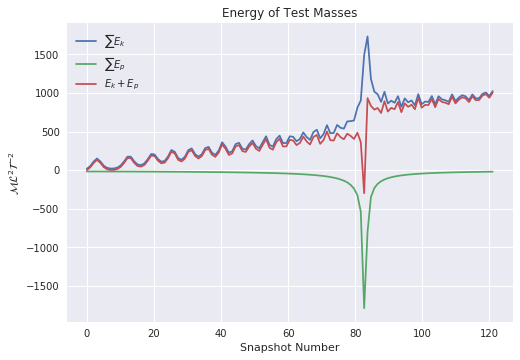

In [30]:
plt.clf()
# 2Body Energy Savr 

ML = [m1,m2]
KS = np.zeros(int(EndNum))
PS = np.zeros(int(EndNum))

print(len(particles))
for i in range(int(EndNum)):
    
    Data = TMdata[i]
    
    if len(particles) == 2:
        r = Data[0:2] - Data[6:8]
        rN = np.linalg.norm(r)
    
        PS[i] = -1*m1*m2/rN
    
    
    for particleID in range(len(particles)):
        Vx = Data[int(6*particleID+3)]
        Vy = Data[int(6*particleID+4)]
        Vz = Data[int(6*particleID+5)]
        
        KS[i] = KS[i] + 1/2*ML[particleID]*(Vx**2+Vy**2+Vz**2) 

Tp = np.linspace(0,EndNum,EndNum)    

plt.figure()
plt.plot(Tp,KS,label = '$\sum E_k$')

if len(particles) == 2:
    plt.plot(Tp,PS,label = '$\sum E_p$')
    plt.plot(Tp,PS+KS,'-', label = '$E_k + E_p$')
#plt.plot(Tp,0*Tp,'k--')

plt.title('Energy of Test Masses')
plt.xlabel('Snapshot Number')
plt.ylabel('$\mathcal{M}\mathcal{L}^2\mathcal{T}^{-2}$')

plt.legend()

plt.show()

In [ ]:
plt.figure()

for i in range(EndNum):
    plt.plot(i,TMdata[i][3],'r.')
    plt.plot(i,TMdata[i][4],'g.')
    plt.plot(i,TMdata[i][5],'b.')

plt.show()


# Advanced Energy Processing Unit

In [ ]:
fig = plt.figure(figsize=(8, 4.5))

egylist = np.load('{}{}'.format(loc, '/egylist.npy')).tolist()
egpcmlist = np.load('{}{}'.format(loc, '/egpcmlist.npy')).tolist()
egpsilist = np.load('{}{}'.format(loc, '/egpsilist.npy')).tolist()
ekandqlist = np.load('{}{}'.format(loc, '/ekandqlist.npy')).tolist()
mtotlist = np.load('{}{}'.format(loc, '/masseslist.npy')).tolist()


plt.plot(egylist,'g-',label='Total ULDM Energy')
plt.plot(egpcmlist,'c-.',label='$E_{GP}$ (ULD Potential Due to Test Masses)')
plt.plot(egpsilist,'m-.',label='$E_{GP}$ (ULD Potential Due to Self-Interaction)')
plt.plot(ekandqlist,label='ULD $E_{K}+E_{Q}$')


plt.plot(Tp,KS,'y--',label = '$\sum E_k$ for Test Masses')

if len(particles) == 2:
    plt.plot(Tp,PS,'r--',label = '$\sum E_p$ for Test Masses')
    plt.plot(Tp,PS+KS,'b-', label = 'Total Energy of Test Masses')
    
#plt.plot(Tp,0*Tp,'k--')


plt.plot(Tp,PS+KS+egylist,'k-', label = 'Total Energy of Entire System')

plt.legend(loc='best', bbox_to_anchor=(0.5, 1.3), frameon=False, ncol=2)

plt.xlabel('Snapshot Number')
plt.ylabel('Net Energy / $\mathcal{M}\mathcal{L}^2\mathcal{T}^{-2}$')

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)


plt.savefig('energy_diagram.eps', format='eps', dpi=1000)
plt.savefig('energy_diagram.jpg', format='jpg', dpi=300)

plt.xlim([2,EndNum])

plt.show()


In [ ]:
fig = plt.figure(figsize=(8, 4.5))

Tpt = np.linspace(1,EndNum,EndNum-2,endpoint = False) 

egylist = np.array(np.load('{}{}'.format(loc, '/egylist.npy')).tolist())
egpcmlist = np.array(np.load('{}{}'.format(loc, '/egpcmlist.npy')).tolist())
egpsilist = np.array(np.load('{}{}'.format(loc, '/egpsilist.npy')).tolist())
ekandqlist = np.array(np.load('{}{}'.format(loc, '/ekandqlist.npy')).tolist())
mtotlist = np.load('{}{}'.format(loc, '/masseslist.npy')).tolist()


egylistD = egylist - egylist[1]

egpcmlistD = egpcmlist - egpcmlist[1]

egpsilistD = egpsilist - egpsilist[1]

ekandqlistD = ekandqlist - ekandqlist[1]


plt.plot(egylistD[1:-1],'g-',label='Total ULDM Energy')
plt.plot(egpcmlistD[1:-1],'c-.',label='$E_{GP}$ (ULD Potential Due to Test Masses)')
plt.plot(egpsilistD[1:-1],'m-.',label='$E_{GP}$ (ULD Potential Due to Self-Interaction)')
plt.plot(ekandqlistD[1:-1],label='ULD $E_{K}+E_{Q}$')

KSD = KS - KS[1]

PSD = PS - PS[1]
#plt.plot(Tp,KS,'y--',label = '$\sum E_k$ for Test Masses')

if len(particles) == 2:
    #plt.plot(Tp,PS,'r--',label = '$\sum E_p$ for Test Masses')
    plt.plot(Tpt,PSD[1:-1]+KSD[1:-1],'b-', label = 'Total Energy of Test Masses')
    
#plt.plot(Tp,0*Tp,'k--')


plt.plot(Tpt,PSD[1:-1]+KSD[1:-1]+egylistD[1:-1],'k-', label = 'Total Energy of Entire System')

plt.legend(loc='best', bbox_to_anchor=(0.5, 1.3), frameon=False, ncol=2)

plt.xlabel('Snapshot Number')
plt.ylabel('Energy Change/$\mathcal{M}\mathcal{L}^2\mathcal{T}^{-2}$')

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

plt.savefig('energy_diagram.eps', format='eps', dpi=1000)
plt.savefig('energy_diagram.jpg', format='jpg', dpi=300)

plt.xlim([2,EndNum])

plt.show()


In [ ]:
plt.plot(egpcmlist,'c-.',label='$E_{GP}$ (ULD Potential Due to Test Masses)')
plt.xlabel('Snapshot Number')
plt.ylabel('$\mathcal{M}\mathcal{L}^2\mathcal{T}^{-2}$')

plt.show()

# 3D Field Visualization

Loads all data into RAM. Very slow.

In [ ]:


if save_rho:
    
    with open('{}{}'.format(save_path, '/timestamp.txt'), 'r') as timestamp:
        ts = timestamp.read()
        print('PyUL NBody: Loading Folder',ts)

    loc = save_path + '/' + ts

    import time   
    import warnings 
    warnings.filterwarnings("ignore")
    plt.ioff()

    EndNum = 0
    Rhodata = []
    TMdata = []

    for x in np.arange(0,save_number+1,1):
    #for x in np.arange(0,550,1):    

        try:

            Rhodata.append(np.load('{}{}{}{}'.format(loc, '/rho_#', x, '.npy')))
            TMdata.append(np.load('{}{}{}{}'.format(loc, '/TM_#', x, '.npy')))
            EndNum += 1
        except FileNotFoundError:

            TimeStamp = ts
            print("PyUL NBody: Run incomplete or the storage is corrupt!")

            break

    print("PyUL NBody: Loaded", EndNum, "Data Entries. Which one to plot?")
    
    PlotNum = int(input())

    import plotly.graph_objects as go
    
    import plotly.io as pio
    
    import numpy as np
    
    if Uniform:
        Rhodata = np.log(np.array(Rhodata))
        
    

    HL = length/2
    XP, YP, ZP = np.mgrid[-HL:HL:resol/4*1j, -HL:HL:resol/4*1j, -HL:HL:resol/4*1j]

    print(len(XP))
    values = Rhodata[PlotNum]
    
    values = values.flatten()
    
    shrink = int(resol/4)**3
    
    Values = np.zeros(shrink)
    
    for ii in range(shrink):
        Values[ii] = values[int(ii*4)]

    fig3D = go.Figure(data=go.Volume(
        x=XP.flatten(),
        y=YP.flatten(),
        z=ZP.flatten(),
        value=Values,
        isomin=np.min(Rhodata),
        isomax=np.max(Rhodata),
        opacity=0.02, # needs to be small to see through all surfaces
        surface_count=int(resol/4), # needs to be a large number for good volume rendering
        ))
    
    
else:
    print("You did not save field data!")

In [ ]:
import plotly.io as pio
pio.write_html(fig3D, 'Trial.html')